In [7]:
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from collections import deque
import networkx as nx
import time
import heapq

In [2]:
%pip install gym

     ---------------------------------------- 0.0/721.7 kB ? eta -:--:--
     --- ----------------------------------- 61.4/721.7 kB 1.6 MB/s eta 0:00:01
     ------- ------------------------------ 143.4/721.7 kB 2.1 MB/s eta 0:00:01
     ------------ ------------------------- 235.5/721.7 kB 2.0 MB/s eta 0:00:01
     ----------------- -------------------- 337.9/721.7 kB 2.1 MB/s eta 0:00:01
     ---------------------- --------------- 430.1/721.7 kB 2.2 MB/s eta 0:00:01
     -------------------------- ----------- 501.8/721.7 kB 2.1 MB/s eta 0:00:01
     ----------------------------- -------- 563.2/721.7 kB 2.0 MB/s eta 0:00:01
     ------------------------------------ - 696.3/721.7 kB 2.1 MB/s eta 0:00:01
     -------------------------------------- 721.7/721.7 kB 2.0 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with statu


[notice] A new release of pip is available: 23.3.2 -> 25.0.1
[notice] To update, run: C:\Users\etien\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [8]:
# A* Pathfinding Algorithm
class AStarPathfinder:
    def __init__(self, grid_size, obstacles):
        self.grid_size = grid_size
        self.obstacles = obstacles

    def heuristic(self, a, b):
        return abs(a[0] - b[0]) + abs(a[1] - b[1])

    def get_neighbors(self, node):
        x, y = node
        neighbors = [(x+1, y), (x-1, y), (x, y+1), (x, y-1)]
        return [n for n in neighbors if 0 <= n[0] < self.grid_size[0] and 0 <= n[1] < self.grid_size[1] and n not in self.obstacles]

    def find_path(self, start, goal):
        open_list = []
        heapq.heappush(open_list, (0, start))
        came_from = {}
        g_score = {start: 0}
        f_score = {start: self.heuristic(start, goal)}

        while open_list:
            _, current = heapq.heappop(open_list)
            if current == goal:
                path = []
                while current in came_from:
                    path.append(current)
                    current = came_from[current]
                path.reverse()
                return path

            for neighbor in self.get_neighbors(current):
                tentative_g_score = g_score[current] + 1
                if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = tentative_g_score + self.heuristic(neighbor, goal)
                    heapq.heappush(open_list, (f_score[neighbor], neighbor))
        return []

In [9]:
# Set device: Use GPU if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# UAV Environment with A* and Decentralized RL Comparison
class UAVEnv:
    def __init__(self, grid_size=(10, 10), num_drones=3):
        self.grid_size = grid_size
        self.num_drones = num_drones
        self.action_space = ["up", "down", "left", "right", "stay"]
        self.obstacles = self.generate_dynamic_obstacles()
        self.goal = (9, 9)
        self.communication_range = 3  # Drones must stay within this range
        self.astar = AStarPathfinder(self.grid_size, self.obstacles)
        self.reset()

    def reset(self):
        self.drones = [(0, i) for i in range(self.num_drones)]
        return self.get_state()

    def generate_dynamic_obstacles(self):
        return {(random.randint(2, 8), random.randint(2, 8)) for _ in range(10)}

    def get_state(self):
        return np.array(self.drones).flatten()  # Return a NumPy array for GPU compatibility

    def step(self, actions):
        new_positions = []
        for i, (x, y) in enumerate(self.drones):
            action = actions[i]
            next_pos = (x, y)
            if action == "up": next_pos = (x, y + 1)
            elif action == "down": next_pos = (x, y - 1)
            elif action == "left": next_pos = (x - 1, y)
            elif action == "right": next_pos = (x + 1, y)
            if next_pos in self.obstacles: next_pos = (x, y)
            new_positions.append(next_pos)
        if len(set(new_positions)) < len(new_positions): return self.get_state(), -20, False
        for i in range(self.num_drones):
            for j in range(i + 1, self.num_drones):
                if np.linalg.norm(np.array(new_positions[i]) - np.array(new_positions[j])) > self.communication_range:
                    return self.get_state(), -10, False
        self.drones = new_positions
        reward = -1
        done = all(drone == self.goal for drone in self.drones)
        if done: reward = 100
        return self.get_state(), reward, done

In [6]:
device

device(type='cpu')

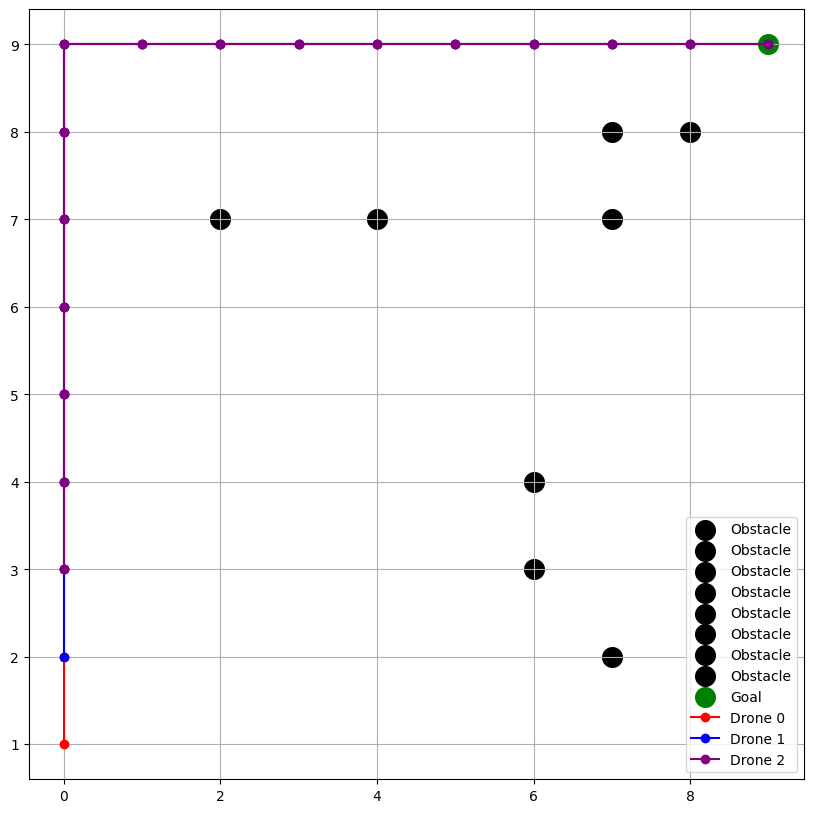

'\nThis implementation introduces:\n- A* search for initial path planning to improve efficiency\n- Centralized vs. decentralized reinforcement learning comparison\n- Visualization of learned paths\n'

In [10]:
# Visualization of learned paths
def visualize_paths(env, paths):
    plt.figure(figsize=(10, 10))
    for state in env.obstacles:
        plt.scatter(state[0], state[1], color='black', s=200, label='Obstacle')
    plt.scatter(env.goal[0], env.goal[1], color='green', s=200, label='Goal')
    colors = ['red', 'blue', 'purple']
    for i, path in enumerate(paths):
        if path:
            x_vals, y_vals = zip(*path)
            plt.plot(x_vals, y_vals, color=colors[i % len(colors)], marker='o', label=f'Drone {i}')
    plt.legend()
    plt.grid(True)
    plt.show()

# A* Path Planning for Drones
env = UAVEnv()
drone_paths = [env.astar.find_path(start, env.goal) for start in env.drones]
visualize_paths(env, drone_paths)


"""
This implementation introduces:
- A* search for initial path planning to improve efficiency
- Centralized vs. decentralized reinforcement learning comparison
- Visualization of learned paths
"""